In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer import FreeFlyer
from utils import *
import pickle, os
from tqdm import tqdm
from para import paraset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'#不设这个解不出#

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\msi\anaconda3\envs\coco\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## shortest path generate horizon

In [3]:
paraset(N=8,n_obs=5,Qs=1,Rs=0,num_probs=10000,obs_fix=True,xg_fix=False)

In [6]:
# load setting file and plot obstacles
Qs=1
N=8
#pass the value from config to dict and para
relative_path = os.getcwd()
dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#

prob = FreeFlyer(config=config_fn)
#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)
Z = np.zeros((num_probs, 2*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob.sampled_params = ['x0', 'xg', 'obstacles']

#solving MICP
ii_toggle = 0
obs_new_ct = 5
ii=0
obstacles = config[-1]

if obs_fix:
    for ii in tqdm(range(num_probs)):
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
            # with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:], Z[ii,:,:] = optvals
            ii += 1

elif not obs_fix:
    print('solving non-fix obs')
    if ii <= num_probs:
        obstacles = random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
            #with time_limit(30):
            prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
            ii += 1
else:
    print('choose to fix obstalce')
num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]
Z = Z[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:],Z[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:], Z[:num_train,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()


  0%|          | 0/10000 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2022-12-22
Using license file C:\Users\msi\gurobi.lic


  0%|          | 31/10000 [00:07<29:37,  5.61it/s] C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)
100%|██████████| 10000/10000 [21:47<00:00,  7.65it/s]


## default generate horizon

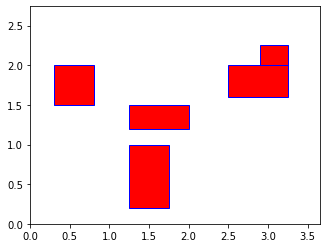

In [3]:
# load setting file and plot obstacles
Qs=1
N=8
#pass the value from config to dict and para
relative_path = os.getcwd()
# dataset_name = 'Fo_Mxg_Q_{}_horizon_{}'.format(Qs, N)
dataset_name = 'STL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

prob_params = {}
prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T

obstacles = []
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')
    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [91]:
prob = FreeFlyer(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train,z_train, c_train, times_train = train_data
train_file.close()

x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test, c_test, times_test = test_data
test_file.close()

In [94]:
train_data[3][2]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 0]])

In [88]:
from solvers.coco_ff import CoCo_FF

system = 'free_flyer'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','xg','obstacles_map']

coco_obj = CoCo_FF(system, prob, prob_features)

n_features = 33
coco_obj.construct_strategies(n_features, train_data)
print(coco_obj.n_strategies)
coco_obj.strategy_dict

494


{(1,
  1,
  1,
  2,
  2,
  2,
  2): array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0]),
 (1,
  1,
  1,
  1,
  1,
  3,
  3): array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1]),
 (1,
  1,
  1,
  1,
  1,
  1,
  1): array([2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]),
 (0,
  2,
  2,
  2,
  2,
  2,
  2): array([3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0]),
 (0,
  0,
  0,
  0,
  2,
  2,
  2): array([4, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0]),
 (1,
  3,
  3,
  3,
  3,
  3,
  3): array([5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1]),
 (1,
  1,
  3,
  3,
  3,
  3,
  3): array([6, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1]),
 (0,
  0,
  0,
  0,



# default generation

In [155]:
def generate_horizon(N, n_obs=8):
    n = 2; m = 2

    dh = 0.75
    Ak = np.eye(2*n)
    Ak[:n,n:] = dh*np.eye(n)
    Bk = np.zeros((2*n,m))
    Bk[:n,:] = 0.5*dh**2 * np.eye(n)
    Bk[n:,:] = dh*np.eye(n)

    Q = 200* np.diag([2,2,1,1.])
    R = 1000.*np.eye(m)

    mass_ff_min = 15.36
    mass_ff_max = 18.08
    mass_ff = 0.5*(mass_ff_min+mass_ff_max)
    thrust_max = 2*1.  # max thrust [N] from two thrusters
    umin = -thrust_max/mass_ff
    umax = thrust_max/mass_ff
    velmin = -0.2
    velmax = 0.2
    posmin = np.zeros(n)

    ft2m = 0.3048
    posmax = ft2m*np.array([12.,9.])
    max_box_size = 0.75
    min_box_size = 0.25
    box_buffer = 0.025
    border_size = 0.05

    prob_params = [N, Ak, Bk, Q, R, n_obs , \
        posmin, posmax, velmin, velmax, umin, umax]

    #setup filenames
    relative_path = os.getcwd()
    dataset_name = 'default_horizon_{}'.format(N)

    if not os.path.isdir(os.path.join(relative_path, 'data', dataset_name)):
        os.mkdir(os.path.join(relative_path+'/data/'+dataset_name))

    if not os.path.isdir(os.path.join(relative_path, 'config')):
        os.mkdir(os.path.join(relative_path, 'config'))

    train_fn = 'train_horizon_{}.p'.format(N)
    train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
    test_fn = 'test_horizon_{}.p'.format(N)
    test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

    #define all possible params that can be varied
    all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
        'posmin', 'posmax', 'velmin', 'velmax', \
        'umin', 'umax', \
        'x0', 'xg', 'obstacles']

    param_dict = {'N':N, 'Ak':Ak, 'Bk':Bk, 'Q':Q, 'R':R, 'n_obs':n_obs, \
        'posmin':posmin, 'posmax':posmax, 'velmin':velmin, 'velmax':velmax, \
        'umin':umin, 'umax':umax}

    #specify which parameters to sample, & their distributions
    sampled_params = ['x0', 'xg', 'obstacles']
    sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
                   velmin + (velmax-velmin)*np.random.rand(2))) ,\
                   'xg': lambda: np.hstack((0.9*posmax, np.zeros(n))), \
                   'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)}

    #specify dataset sizes
    num_train = 50000; num_test = 5000
    num_probs = num_train + num_test

    #write out config
    config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

    config = [dataset_name, prob_params, sampled_params]
    outfile = open(config_fn,"wb")
    pickle.dump(config,outfile); outfile.close()

    prob = FreeFlyer(config=config_fn)

    #create numpy containers for data: (params, x, u, y, J*, solve_time)
    params = {}
    if 'x0' in sampled_params:
        params['x0'] = np.zeros((num_probs,2*n))
    if 'xg' in sampled_params:
        params['xg'] = np.zeros((num_probs,2*n))
    if 'obstacles' in sampled_params:
        params['obstacles'] = np.zeros((num_probs, 4, n_obs))

    X = np.zeros((num_probs, 2*n, N));
    U = np.zeros((num_probs, m, N-1))
    Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)

    costs = np.zeros(num_probs)
    solve_times = np.zeros(num_probs)

    total_count = 0
    ii = 0
    ii_obs = 0
    ii_toggle = 0
    obs_new_ct = 5
    toggle_ct = 10
    toggle_obstacles = True

    #big for loop, sampling problem data, solving MICP, & storing
    for ii in tqdm(range(num_probs)):
        total_count += 1
        if total_count % 10 == 0:
            print('Done with problem {}'.format(ii))
            dump_fn = 'testfile_long_horizon_.txt'.format(N)
            file = open(dump_fn,'w')
            file.write('total_count: {}\n'.format(total_count))
            file.write('Problems solved: {}'.format(ii))
            file.close()

        p_dict = {}
        if 'x0' in sampled_params or 'obstacles' in sampled_params:
            if toggle_obstacles:
                x0 = sample_dists['x0']()
                obstacles = find_obs(x0, n_obs, posmin, posmax, \
                                border_size, box_buffer, min_box_size, max_box_size, \
                                ignore_intersection=False)
                if len(obstacles) is not n_obs:
                    continue
                    # obstacles = find_obs(x0, n_obs, \
                    #                 posmin, posmax, border_size, box_buffer, \
                    #                 min_box_size, max_box_size, \
                    #                 ignore_intersection=True)

                if ii_toggle % obs_new_ct == 0:
                    toggle_obstacles = False
                    ii_obs = 0
                    ii_toggle = 0
            else:
                if ii_obs % obs_new_ct == 0:
                    obstacles = random_obs(n_obs, posmin, posmax, \
                                               border_size, box_buffer, \
                                               min_box_size, max_box_size)
                x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

                if ii_toggle % toggle_ct == 0:
                    toggle_obstacles = True
                    ii_obs = 0
                    ii_toggle = 0

            if len(obstacles) is not n_obs:
                continue

            params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
            params['x0'][ii,:] = x0

            p_dict['x0'] = params['x0'][ii,:]
            p_dict['obstacles'] = params['obstacles'][ii,:]

        if 'xg' in sampled_params:
            params['xg'][ii,:] = sample_dists['xg']()
            p_dict['xg'] = params['xg'][ii,:]

        dump_fn = 'dump_data_horizon_.p'.format(N)
        dump_file = open(dump_fn,'wb')
        dump_data = [p_dict['x0'], p_dict['xg'], p_dict['obstacles']]
        pickle.dump(dump_data,dump_file); dump_file.close()

        prob_success = False
        try:
    #         with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))
        #     except (TimeoutException):
    #         print("Timed out at {}!".format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            # pdb.set_trace()
            X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
            ii += 1
            ii_obs += 1
            ii_toggle += 1

    arr = np.arange(num_probs)
    np.random.shuffle(arr)

    X = X[arr]
    U = U[arr]
    Y = Y[arr]

    if 'x0' in sampled_params:
        params['x0'] = params['x0'][arr]
    if 'xg' in sampled_params:
        params['xg'] = params['xg'][arr]
    if 'obstacles' in sampled_params:
        params['obstacles'] = params['obstacles'][arr]

    costs = costs[arr]
    solve_times = solve_times[arr]

    #post-processing + write out
    train_params = {}; test_params = {}
    if 'x0' in sampled_params:
        train_params['x0'] = params['x0'][:num_train,:]
        test_params['x0'] = params['x0'][num_train:,:]
    if 'obstacles' in sampled_params:
        train_params['obstacles'] = params['obstacles'][:num_train,:]
        test_params['obstacles'] = params['obstacles'][num_train:,:]
    if 'xg' in sampled_params:
        train_params['xg'] = params['xg'][:num_train,:]
        test_params['xg'] = params['xg'][num_train:,:]

    train_data = [train_params]
    train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
    train_data += [costs[:num_train], solve_times[:num_train]]

    test_data = [test_params]
    test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
    test_data += [costs[num_train:], solve_times[num_train:]]

    train_file = open(train_fn,'wb')
    pickle.dump(train_data,train_file); train_file.close()

    test_file = open(test_fn, 'wb')
    pickle.dump(test_data,test_file); test_file.close()
    return

In [156]:
generate_horizon(N=7, n_obs=5)

Done with problem 8
Done with problem 13
Done with problem 23
Done with problem 27


# Generate training+test set data with fixed obstacles

### parametet setting, load setting file and plot obstacles

In [95]:
paraset(N=10,n_obs=5,Qs=200,num_probs=20000,obs_fix=True,xg_fix=False)

In [96]:
# load setting file and plot obstacles
Qs=1
N=8
#pass the value from config to dict and para
relative_path = os.getcwd()
# dataset_name = 'Fo_Mxg_Q_{}_horizon_{}'.format(Qs, N)
dataset_name = 'SOS1_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

prob_params = {}
prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T

obstacles = []
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')
    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Curious\\CoCo-master\\free_flyer\\config\\SOS1_1_horizon_8.p'

In [105]:
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#

prob = FreeFlyer(config=config_fn)
#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob.sampled_params = ['x0', 'xg', 'obstacles']


In [113]:
#solving MICP
ii_toggle = 0
obs_new_ct = 5
ii=0
obstacles = config[-1]

if obs_fix:
    for ii in tqdm(range(num_probs)):
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
    #         with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
            ii += 1

elif not obs_fix:
    print('solving non-fix obs')
    if ii <= num_probs:
        obstacles = random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
    #         with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:] = optvals
            ii += 1
else:
    print('choose to fix obstalce')


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


In [114]:
num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

In [115]:
a=train_data[-1]
print(np.mean(a))

0.40099411805470786


## 用来测试default的小R和大R的求解对比

In [50]:
N=6
relative_path = os.getcwd()
# dataset_name = 'default'
dataset_name = 'default_horizon_{}'.format(N)


#加载设置文件config = [dataset_name, [prob_params] ,sampled_params]
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
outfile = open(config_fn,"rb")
config=pickle.load(outfile);outfile.close()

#加载训练文件
train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

if not os.path.isdir(os.path.join(relative_path, 'data', dataset_name)):
    os.mkdir(os.path.join(relative_path+'/data/'+dataset_name))

if not os.path.isdir(os.path.join(relative_path, 'config')):
    os.mkdir(os.path.join(relative_path, 'config'))


train_file = open(train_fn,'rb')
p, x, u, y, c, s = pickle.load(train_file); train_file.close()


prob = FreeFlyer()
sampled_params = ['x0', 'xg', 'obstacles']
sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2))) ,\
               'xg': lambda: np.hstack((0.9*posmax, np.zeros(n))), \
               'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, min_box_size, max_box_size)}

ii = 0
little_R_costs = []
big_R_costs = []
while ii < 100:
    if np.random.rand() < 0.8:
        obstacles = \
            random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
    else:
        x0 = sample_dists['x0']()
        obstacles = find_obs(x0, n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size, ignore_intersection=False)
    if len(obstacles) == 0:
        continue

    p_dict = {}
    p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    p_dict['x0'] = x0
    p_dict['xg'] = sample_dists['xg']()

    prob.Q = np.diag([2,2,1,1.])
    prob.R = 10.*np.eye(2)
    prob.init_bin_problem()
    prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
    print(solve_time)
    if not prob_success:
        print('failed')
        continue
    little_R_costs += [solve_time]

    prob.Q = np.diag([2.,2.,10.,10.])
    prob.R = 1000.*np.eye(2)
    prob.init_bin_problem()
    prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.GUROBI)
    big_R_costs += [solve_time]
    ii += 1
    if ii % 10 == 0:
        print(ii)

0.03125166893005371
0.4218757152557373
0.031240463256835938
0.2812497615814209
0.03121161460876465
0.01562809944152832
0.015625
0.0
failed
0.0937507152557373
40
0.015628576278686523
0.0625009536743164
0.01563262939453125
failed
0.125
0.015624046325683594
0.015627145767211914
0.015588045120239258
0.031209945678710938
0.031222820281982422
0.047007083892822266
0.015628337860107422
failed
0.015625476837158203
50
0.04687237739562988
0.06246638298034668
0.04646873474121094
0.1250004768371582
0.01562952995300293
0.015625
0.015625715255737305
0.031218767166137695
0.1250002384185791
0.031214237213134766
60
0.031249523162841797
0.0624690055847168
0.046842098236083984
0.06259036064147949
0.0468754768371582
0.0
0.031246662139892578
0.031216144561767578
0.031210660934448242
0.10937643051147461
70
0.04684138298034668
0.0312502384185791
0.12496495246887207
0.03121161460876465
0.04687237739562988
0.031219005584716797
0.015626907348632812
0.0468752384185791
0.015625
0.015630722045898438
80
0.0156252384

0.031248807907104492


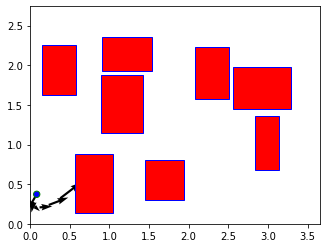

In [55]:
p_dict = {}
obstacles = \
        random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)
x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

# x0 = sample_dists['x0']()
# obstacles = find_obs(x0, posmin, posmax, n_obs, ignore_intersection=False)

p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
p_dict['x0'] = x0
p_dict['xg'] = sample_dists['xg']()

prob_success, cost, solve_time, optvals = prob.solve_micp(p_dict, solver=cp.MOSEK)
print(solve_time)
prob.Q = np.diag([2.,2.,10.,10.])
prob.Q = np.diag([2,2,1,1.])

prob.R = 10.*np.eye(2)
prob.R
prob.init_bin_problem()
idx = np.random.randint(9000)

Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
#     obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obs = p_dict['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = train_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = p_dict['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)
    plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

## 加载训练数据查看情况


In [28]:
#load train/test data
N=10
Qs=1
n_obs=5
dataset_name = 'Fo_Mxg_Q_{}_horizon_{}'.format(Qs, N)
# dataset_name = 'default_horizon_{}'.format(N)
# dataset_name = 'obs_fix_{}'.format(N)
# dataset_name = 'default'

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
prob_params = config[1]
sampled_params = config[2]

config_file.close()#读取设置#

In [29]:
prob = FreeFlyer(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, c_train, times_train = train_data
train_file.close()


x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

In [30]:
from solvers.coco_ff import CoCo_FF

In [31]:
system = 'free_flyer'
prob_features = ['x0','xg','obstacles_map']
# prob_features = ['x0','obstacles_map']

coco_obj = CoCo_FF(system, prob, prob_features)

n_features = 8
coco_obj.construct_strategies(n_features, train_data)
print(coco_obj.n_strategies)
coco_obj.n_evals

4107


2

In [29]:
def train_horizon_N(N, device_id=0):
    relative_path = os.getcwd()
    # config_fn = relative_path + '/config/default_horizon_{}.p'.format(N)
    # config_fn = relative_path + '/config/Fo_Mxg_Q_1_horizon_{}.p'.format
    config_fn = relative_path + '/config/STL_{}_horizon_{}.p'.format(Qs,N)
    config_file = open(config_fn,'rb')
    config =  pickle.load(config_file)
    dataset_name = config[0]; config_file.close()

    dataset_fn = relative_path + '/data/' + dataset_name

    train_fn = os.path.join(dataset_fn, 'train_horizon_{}.p'.format(N))
    train_file = open(train_fn,'rb')
    train_data = pickle.load(train_file)
    train_file.close()
    x_train = train_data[1]
    y_train = train_data[3]

    test_fn = os.path.join(dataset_fn, 'test_horizon_{}.p'.format(N))
    test_file = open(test_fn,'rb')
    test_data = pickle.load(test_file)
    p_test, x_test, u_test, y_test,z_test, c_test, times_test = test_data
    test_file.close()

    n_test = x_test.shape[0]

    system = 'free_flyer'
    prob_features = ['x0', 'xg', 'obstacles']

    prob = FreeFlyer(config=config_fn)
    mlopt = CoCo_FF(system, prob, prob_features)

    n_features = 33
    mlopt.construct_strategies(n_features, train_data)

    print('Number of strategies for horizon {}: {}'.format(N, mlopt.n_strategies))

    mlopt.setup_network(device_id=device_id)
    # mlopt.model_fn = 'D:\Curious\CoCo-master\models/CNN_Fo_Mxg_Q_200_horizon_{}.pt'.format(N)
    # mlopt.model_fn = 'D:\Curious\CoCo-master/models/lowE_Fo_Mxg_Q_1_horizon_{}.pt'.format(N)
    mlopt.model_fn = 'D:\Curious\CoCo-master/models/STL_horizon_{}.pt'.format(N)
    mlopt.training_params['TRAINING_ITERATIONS'] = 100
    mlopt.train(train_data=train_data, verbose=True)

In [30]:
train_horizon_N(8)

Number of strategies for horizon 8: 494
Done with epoch 0 in 2.0158817768096924s
Done with epoch 1 in 1.484492540359497s
loss:   2.3910105228424072,   acc:  0.46875
Done with epoch 2 in 1.484459400177002s
Done with epoch 3 in 1.479076862335205s
Done with epoch 4 in 1.5000057220458984s
loss:   1.5358976125717163,   acc:  0.5
Done with epoch 5 in 1.470435619354248s
Done with epoch 6 in 1.4296724796295166s
Done with epoch 7 in 1.4062488079071045s
loss:   1.6283339262008667,   acc:  0.625
Done with epoch 8 in 1.453352689743042s
Done with epoch 9 in 1.4532392024993896s
Done with epoch 10 in 1.406358003616333s
loss:   1.1286654472351074,   acc:  0.71875
Done with epoch 11 in 1.4376468658447266s
Done with epoch 12 in 1.4376602172851562s
Done with epoch 13 in 1.4532968997955322s
loss:   1.0685946941375732,   acc:  0.75
Done with epoch 14 in 1.5157382488250732s
Done with epoch 15 in 1.4063811302185059s
Done with epoch 16 in 1.2656290531158447s
loss:   1.230776309967041,   acc:  0.71875
Done wit

In [141]:
coco_obj.setup_network()
fn_saved = 'D:\Curious\CoCo-master\models/Fo_Mxg_Q_200_horizon_6.pt'
fn_saved ='D:\Curious\CoCo-master/Fo_Mxg_horizon_{}.pt'.format(N)
fn_saved = 'D:\Curious\CoCo-master/Fo_Mxg_Q_1_horizon_{}.pt'.format(N)
fn_saved = 'D:\Curious\CoCo-master/models/lowE_Fo_Mxg_Q_1_horizon_{}.pt'.format(N)
fn_saved = 'D:\Curious\CoCo-master/models/STL_horizon_{}.pt'.format(N)
# fn_saved = 'D:\Curious\CoCo-master\models\obs_fix_horizon_6.pt'
# fn_saved = 'mloptff_free_flyer_20200726_1455.pt'
coco_obj.load_network(fn_saved)
coco_obj.prob_features
coco_obj.model

Loading presaved classifier model from D:\Curious\CoCo-master/models/STL_horizon_8.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=494, bias=True)
  )
)

In [83]:
velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]
x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)

In [33]:
sampled_params = ['x0', 'xg', 'obstacles']
sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2))) ,\
               'xg': lambda: np.hstack((0.9*posmax, np.zeros(2))), \
               'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)}

# obstacles = sample_dists['obstacles']()

In [162]:
prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    # prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    # x0 = sample_dists['x0']()
    # xg = sample_dists['xg']()
    # prob_params['x0'] = x0
    # prob_params['xg'] = xg

    prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')


Found solution! n_evals = 1


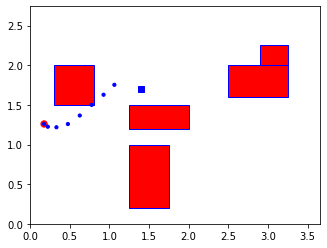

In [163]:
Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = prob_params['x0']
xg = prob_params['xg']


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

## 加载config给para赋值

In [121]:
relative_path = os.getcwd()

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#设置文件地址，config = [dataset_name, prob_params, sampled_params]#
config_file = open(config_fn,'rb')
config = pickle.load(config_file)
dataset_name = config[0]
prob_params = config[1]
sampled_params = config[2];
config_file.close()#读取设置#

p=prob_params
p_dict = {}


all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']

# num_probs = config[3]
# border_size = config[4]
# box_buffer = config[5]
# min_box_size = config[6]
# max_box_size = config[7]
# posmin = config[8]
# posmax = config[9]
# velmin = config[10]
# velmax = config[11]
# n = config[12]
# m= config[13]
#
# obs_fix = config[14]
# xg_fix = config[15]
# if obs_fix:
#     obstacles = config[16]

#
# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)

# x0 = sample_dists['x0']()
# obstacles = find_obs(x0, posmin, posmax, n_obs, ignore_intersection=False)

# p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
# p_dict['x0'] = x0
# p_dict['xg'] = xg
config

['default',
 [6, array([[1.  , 0.  , 0.75, 0.  ],
         [0.  , 1.  , 0.  , 0.75],
         [0.  , 0.  , 1.  , 0.  ],
         [0.  , 0.  , 0.  , 1.  ]]), array([[0.28125, 0.     ],
         [0.     , 0.28125],
         [0.75   , 0.     ],
         [0.     , 0.75   ]]), array([[2., 0., 0., 0.],
         [0., 2., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]), array([[1000.,    0.],
         [   0., 1000.]]), 8, array([0., 0.]), array([3.6576, 2.7432]), -0.2, 0.2, -0.11961722488038279, 0.11961722488038279],
 ['x0', 'xg', 'obstacles']]

In [2]:
idx = np.random.randint(train_data[1].shape[0])
Xopt = train_data[1][idx]
obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    # obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

x0 = train_data[0]['x0'][idx]
xg = train_data[0]['xg'][idx]
# x0 = test_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
# x0 = prob_params['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

NameError: name 'train_data' is not defined

In [137]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.MOSEK, max_evals=10)

if prob_success:
    print(n_evals)
else:
    print('Failed')

Failed


None


## 测试forward预测

In [3]:
prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
        # prob_params['obstacles'] = p_dict['obstacles']
        # prob_params['x0'] = p_dict['x0']
        # prob_params['xg'] = p_dict['xg']

    prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.MOSEK, max_evals=6)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')


NameError: name 'test_data' is not defined

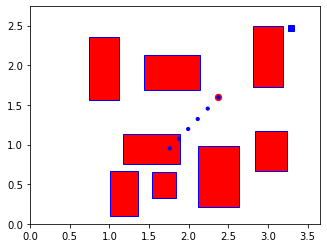

In [152]:
Xopt = optvals[0]
obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    # obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

x0 = prob_params['x0']
xg = prob_params['xg']

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
# x0 = prob_params['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [153]:
from pytorch.models import FFNet
import random
import time
from torch import optim

ff_shape=[]
for ii in range(3):
    ff_shape.append(128)
ff_shape.append(coco_obj.n_strategies)
ff_shape.insert(0, coco_obj.n_features)
len(ff_shape)


layers = []
for ii in range(0,len(ff_shape)-1):
    layers.append(torch.nn.Linear(ff_shape[ii],ff_shape[ii+1]))

layers = torch.nn.ModuleList(layers)
layers
coco_obj.model


rand_idx = list(np.arange(0,X.shape[0]-1))
random.shuffle(rand_idx)

bz=64
for ii in range((len(rand_idx) + bz - 1) // bz):
    indices = rand_idx[ii * bz:(ii + 1) * bz]


for ii,idx in enumerate(indices):
    labels = Variable(torch.from_numpy(Y[idx])).long().to(device=coco_obj.device)
    ff_inputs = Variable(torch.from_numpy(X[idx,:])).float().to(device=coco_obj.device)
    # print(labels)
    # print(ff_inputs)
    # outputs = coco_obj.model(ff_inputs)


training_loss = torch.nn.CrossEntropyLoss()
# outputs=torch.unsqueeze(outputs,0)

# class_guesses = torch.argmax(outputs, 1)
inpt=Variable(torch.from_numpy(coco_obj.features)).unsqueeze(0).float()


coco_obj.model.to(device=torch.device('cpu'))
with torch.no_grad():
    scores = coco_obj.model(inpt).cpu().detach().numpy()[:].squeeze()


coco_obj.n_evals=4
ind_max = np.argsort(scores, axis=1)[:,-coco_obj.n_evals:][:,::-1]
# # outputs
# func=torch.nn.CrossEntropyLoss()
# a=torch.Tensor([[ 0.0606,0.1610,0.2990,0.2101, 0.5104],
#                 [0.6388,0.4053, 0.4196, 0.7060, 0.2793],
#                 [ 0.3973,0.6114, 0.1127, 0.7732, 0.0592]])
# b=[3,1,0]
# #
# b=torch.Tensor(b)
# loss=func(a,b.long())
# loss=func(a,b.long())
# print("总loss:",loss)

obs_strats = {}
uniq_idxs = np.unique(ind_max)
uniq_idxs

TypeError: forward() missing 1 required positional argument: 'feature_batch'

In [41]:
ind_max

array([[351, 304, 385, 308],
       [351, 304, 308, 385],
       [351, 308, 304, 385],
       ...,
       [351, 308, 304,  77],
       [351, 308, 304,  77],
       [351, 308, 304, 385]], dtype=int64)

In [12]:
obs_strats = {}
uniq_idxs = np.unique(ind_max)

for ii,idx in enumerate(uniq_idxs):
    for jj in range(coco_obj.labels.shape[0]):
        # first index of training label is that strategy's idx
        label = coco_obj.labels[jj]
        if label[0] == idx:
            # remainder of training label is that strategy's binary pin
            obs_strats[idx] = label[1:]


In [13]:
import  itertools
vv = [np.arange(0,coco_obj.n_evals) for _ in range(coco_obj.problem.n_obs)]
strategy_tuples = list(itertools.product(*vv))#创建combaination list, 大小为n_eval**n_obs#
strategy_tuples

[(0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 3),
 (0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 0, 0, 1, 3),
 (0, 0, 0, 0, 0, 0, 2, 0),
 (0, 0, 0, 0, 0, 0, 2, 1),
 (0, 0, 0, 0, 0, 0, 2, 2),
 (0, 0, 0, 0, 0, 0, 2, 3),
 (0, 0, 0, 0, 0, 0, 3, 0),
 (0, 0, 0, 0, 0, 0, 3, 1),
 (0, 0, 0, 0, 0, 0, 3, 2),
 (0, 0, 0, 0, 0, 0, 3, 3),
 (0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 0, 1, 0, 2),
 (0, 0, 0, 0, 0, 1, 0, 3),
 (0, 0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 0, 1, 1, 2),
 (0, 0, 0, 0, 0, 1, 1, 3),
 (0, 0, 0, 0, 0, 1, 2, 0),
 (0, 0, 0, 0, 0, 1, 2, 1),
 (0, 0, 0, 0, 0, 1, 2, 2),
 (0, 0, 0, 0, 0, 1, 2, 3),
 (0, 0, 0, 0, 0, 1, 3, 0),
 (0, 0, 0, 0, 0, 1, 3, 1),
 (0, 0, 0, 0, 0, 1, 3, 2),
 (0, 0, 0, 0, 0, 1, 3, 3),
 (0, 0, 0, 0, 0, 2, 0, 0),
 (0, 0, 0, 0, 0, 2, 0, 1),
 (0, 0, 0, 0, 0, 2, 0, 2),
 (0, 0, 0, 0, 0, 2, 0, 3),
 (0, 0, 0, 0, 0, 2, 1, 0),
 

In [14]:
import  itertools
# obs_strats
vv = [np.arange(0,coco_obj.n_evals) for _ in range(coco_obj.problem.n_obs)]
strategy_tuples = list(itertools.product(*vv))

max_evals=16
probs_str = [1./(np.sum(st)+1.) for st in strategy_tuples]  # lower sum(st) values --> better
probs_str = probs_str / np.sum(probs_str)
str_idxs = np.random.choice(np.arange(0,len(strategy_tuples)), max_evals, p=probs_str)
str_idxs


if 0 in str_idxs:
    str_idxs = np.unique(np.insert(str_idxs, 0, 0))
else:
    str_idxs = np.insert(str_idxs, 0, 0)[:-1]

strategy_tuples = [strategy_tuples[ii] for ii in str_idxs]
strategy_tuples

[(0, 0, 0, 0, 0, 0, 0, 0),
 (1, 3, 0, 1, 1, 1, 2, 3),
 (0, 2, 1, 3, 1, 2, 3, 0),
 (2, 3, 2, 0, 3, 1, 3, 1),
 (3, 0, 0, 1, 2, 1, 0, 2),
 (1, 3, 1, 1, 1, 1, 1, 2),
 (0, 2, 2, 1, 1, 2, 2, 0),
 (1, 1, 0, 0, 3, 3, 1, 2),
 (1, 3, 0, 1, 3, 0, 3, 3),
 (2, 3, 3, 1, 1, 0, 2, 3),
 (1, 3, 2, 0, 3, 1, 0, 0),
 (1, 3, 1, 3, 1, 2, 0, 2),
 (3, 0, 0, 2, 0, 0, 3, 0),
 (0, 2, 0, 0, 3, 2, 3, 0),
 (0, 2, 2, 0, 3, 3, 3, 0),
 (0, 0, 2, 1, 1, 2, 1, 3)]

In [15]:
y_guess = -np. ones((4*8, coco_obj.problem.N-1))

for ii, str_tuple in enumerate(strategy_tuples):
    for ii_obs in range(5):
    # rows of ind_max correspond to ii_obs, column to desired strategy
        y_obs = obs_strats[ind_max[ii_obs, str_tuple[ii_obs]]]
        y_guess[4*ii_obs:4*(ii_obs+1)] = np.reshape(y_obs, (4,coco_obj.problem.N-1))


KeyError: 43

设置一下测试问题的参数